In [1]:
import yaml
from api.source.operators.controller import Controller

In [4]:
with open("api\configs\pipeline.yml", "r") as file:
    config = yaml.safe_load(file)

In [5]:
controller_instance = Controller(config)

In [6]:
controller_instance.process_video()

In [16]:
controller_instance.switch_model("faster_rcnn")

In [15]:
controller_instance.switch_camera("traffic_vn")

In [4]:
from ultralytics import YOLO

In [7]:
model = YOLO("api/data/models/one-stage/yolo11-noaugment.pt")

In [11]:
results = model.track(source="api/data/samples/videos/Traffic_VN_scaled.mp4", show=True, conf=0.5, stream=True)

In [8]:
import torch
from ultralytics import YOLO, RTDETR
from torchvision import transforms

from api.source.engines.detectors.FasterRCNN import FRCNN

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
frcnn_model = FRCNN(num_classes=5)
checkpoint = torch.load(
    "api/data/models/two-stage/frcnn_best.pt",
    map_location=device,
    weights_only=True)
frcnn_model.load_state_dict(checkpoint["model_state_dict"])
frcnn_model.to(device)
frcnn_model.eval()
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(640, 640)),
])

In [11]:
yolo_model = YOLO("api/data/models/one-stage/yolo11-noaugment.pt")
rtdetrv2_model = RTDETR("api/data/models/transformer-based/rtdetrv2-nano-resnet.pt")

In [15]:
total_params_yolo = sum(p.numel() for p in yolo_model.model.parameters())
trainable_params_yolo = sum(p.numel() for p in yolo_model.model.parameters() if p.requires_grad)

total_params_rtdetr = sum(p.numel() for p in rtdetrv2_model.model.parameters())
trainable_params_rtdetr = sum(p.numel() for p in rtdetrv2_model.model.parameters() if p.requires_grad)

total_params_frcnn = sum(p.numel() for p in frcnn_model.parameters())
trainable_params_frcnn = sum(p.numel() for p in frcnn_model.parameters() if p.requires_grad)

print(f"YOLO model parameters: {total_params_yolo:,} total, {trainable_params_yolo:,} trainable")
print(f"RTDETR model parameters: {total_params_rtdetr:,} total, {trainable_params_rtdetr:,} trainable")
print(f"Faster R-CNN model parameters: {total_params_frcnn:,} total, {trainable_params_frcnn:,} trainable")

YOLO model parameters: 2,590,620 total, 0 trainable
RTDETR model parameters: 2,830,408 total, 0 trainable
Faster R-CNN model parameters: 5,404,872 total, 5,404,872 trainable


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cap = cv2.VideoCapture("api/data/samples/videos/Traffic_VN.mp4")

In [3]:
ret, frame = cap.read()

In [4]:
frame1 = frame.copy()
frame2 = frame.copy()
frame3 = frame.copy()

In [25]:
cap.release()

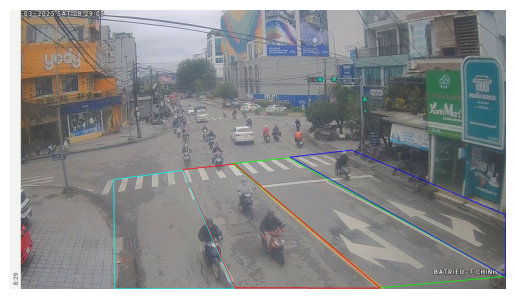

In [7]:
lane_1 = [[864, 594], [1079, 572], [1919, 1031], [1433, 1075]]
lane_2 = [[1084, 569], [1322, 542], [1919, 793], [1919, 1031]]
lane_3 = [[669, 617], [870, 596], [1433, 1076], [869, 1075]]
lane_4 = [[401, 656], [669, 620], [867, 1079], [405, 1079]]

cv2.polylines(frame1, [np.array(lane_1)], isClosed=True, color=(0, 255, 0), thickness=2)
cv2.polylines(frame1, [np.array(lane_2)], isClosed=True, color=(255, 0, 0), thickness=2)
cv2.polylines(frame1, [np.array(lane_3)], isClosed=True, color=(0, 0, 255), thickness=2)
cv2.polylines(frame1, [np.array(lane_4)], isClosed=True, color=(255, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

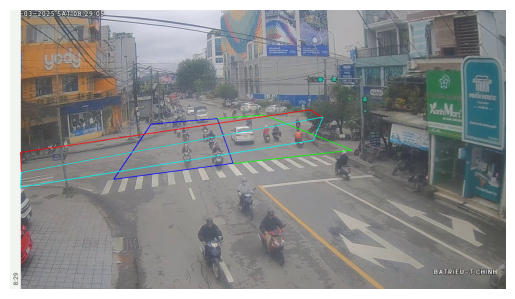

In [8]:
lane_1 = [[801, 420], [984, 406], [1324, 542], [864, 594]]
lane_2 = [[546, 441], [802, 420], [863, 593], [401, 655]]
lane_3 = [[40, 551], [1160, 386], [1208, 414], [43, 627]]
lane_4 = [[43, 628], [1211, 414], [1174, 504], [39, 686]]

cv2.polylines(frame2, [np.array(lane_1)], isClosed=True, color=(0, 255, 0), thickness=2)
cv2.polylines(frame2, [np.array(lane_2)], isClosed=True, color=(255, 0, 0), thickness=2)
cv2.polylines(frame2, [np.array(lane_3)], isClosed=True, color=(0, 0, 255), thickness=2)
cv2.polylines(frame2, [np.array(lane_4)], isClosed=True, color=(255, 255, 0), thickness=2)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [11]:
import numpy as np

# Example list of past positions (x, y)
trajectory = [
    (100, 200),
    (102, 202),
    (105, 205),
    (110, 210)
]

# Convert to NumPy array for easier calculations
points = np.array(trajectory, dtype=np.float32)

# Compute the direction vector from the last two points
direction_vector = points[-1] - points[-2]

# Normalize the direction vector
norm = np.linalg.norm(direction_vector)
if norm != 0:
    unit_vector = direction_vector / norm
else:
    unit_vector = direction_vector  # Handle zero-length vector

print(f"Direction vector: {direction_vector}")
print(f"Unit direction vector: {unit_vector}")


Direction vector: [          5           5]
Unit direction vector: [    0.70711     0.70711]


In [1]:
import cv2
import numpy as np

def scale_video(input_path, output_path, target_width=1280, target_height=720):
    """
    Scale a video from one resolution to another.
    
    Args:
        input_path (str): Path to the input video file
        output_path (str): Path where the scaled video will be saved
        target_width (int): Width of the output video (default: 1280)
        target_height (int): Height of the output video (default: 720)
        
    Returns:
        bool: True if scaling is successful, False otherwise
    """
    try:
        # Open the input video file
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            print(f"Error: Could not open video file {input_path}")
            return False
            
        # Get original video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        # Create VideoWriter object for output
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (target_width, target_height))
        
        # Process and write frames
        processed_frames = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Resize frame to target resolution
            resized_frame = cv2.resize(frame, (target_width, target_height), 
                                      interpolation=cv2.INTER_AREA)
            
            # Write the resized frame to output video
            out.write(resized_frame)
            
            # Update progress
            processed_frames += 1
            if processed_frames % 100 == 0:
                progress = (processed_frames / frame_count) * 100
                print(f"Progress: {progress:.1f}% ({processed_frames}/{frame_count} frames)", end='\r')
        
        # Release resources
        cap.release()
        out.release()
        print(f"Video scaled successfully from {input_path} to {output_path}")
        return True
        
    except Exception as e:
        print(f"Error scaling video: {str(e)}")
        return False
    
scale_video("api/data/samples/videos/cam_8.mp4", "api/data/samples/videos/cam_8_scaled.mp4")

Video scaled successfully from api/data/samples/videos/cam_8.mp4 to api/data/samples/videos/cam_8_scaled.mp4


True

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture("api/data/samples/videos/cam_1.mp4")

ret, frame = cap.read()

cap.release()

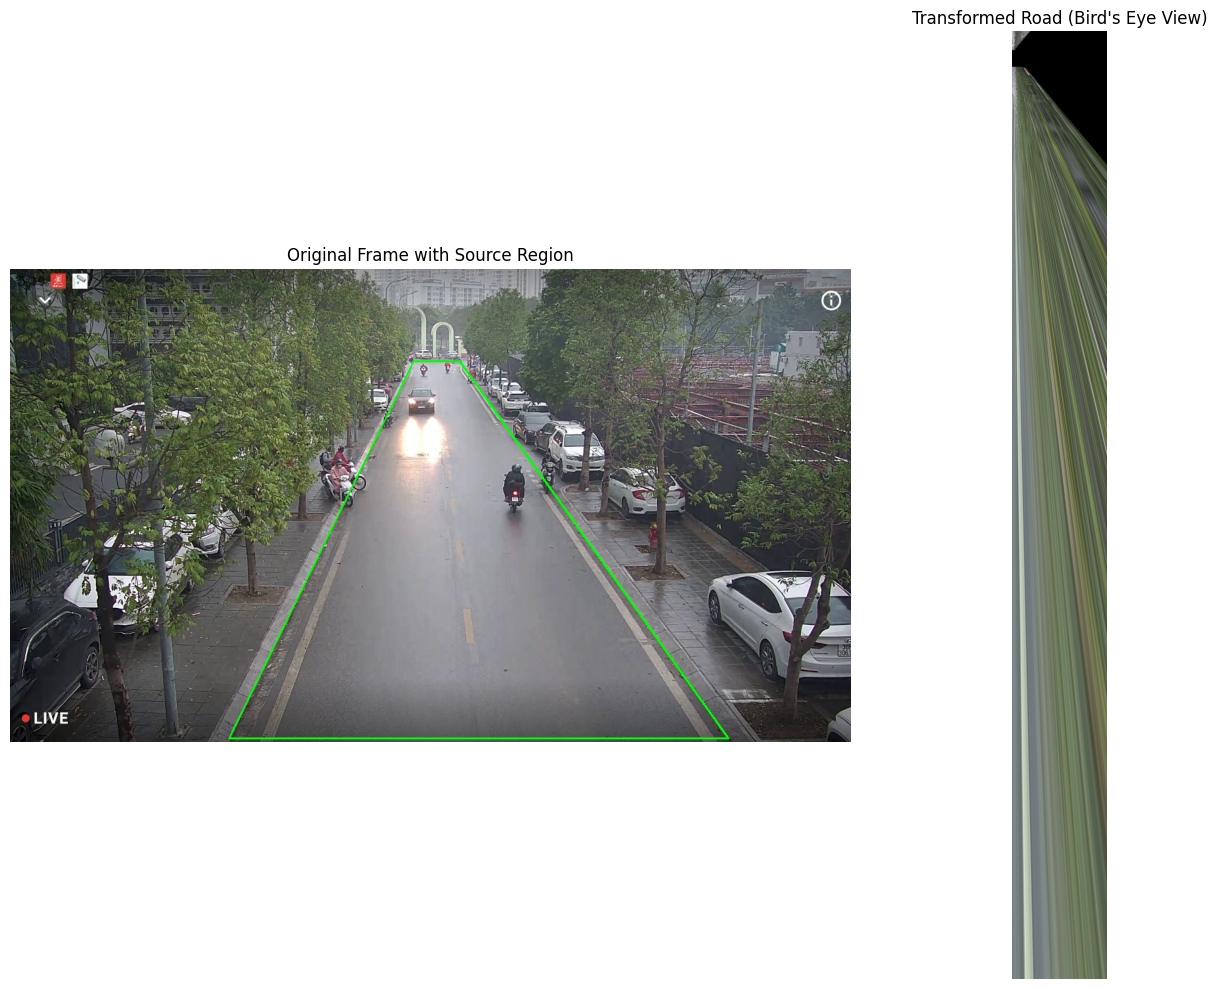

Road dimensions in real world:
Width: 6 meters
Length: 60 meters

Homography matrix:
[[-6.10421836e-02 -2.98830202e-02  4.16635236e+01]
 [ 1.04640009e-15 -8.08224034e-01  1.13151365e+02]
 [ 1.77427583e-17 -1.22297058e-02  1.00000000e+00]]


In [7]:
original_frame = frame.copy()

# Define source points for the polygon
source_points = np.array([[614, 140], [684, 140], [1093, 714], [333, 714]], dtype=np.float32)

# Define target coordinates (where these points should map to in the output)
target_points = np.array([[0, 0], [6, 0], [6, 60], [0, 60]], dtype=np.float32)

# Compute the homography matrix
H, _ = cv2.findHomography(source_points, target_points)

# Mark the source region on the original image
cv2.polylines(original_frame, [np.array(source_points, dtype=np.int32)], 
              isClosed=True, color=(0, 255, 0), thickness=2)

# Apply the perspective transformation to get a bird's eye view
# Make output size larger to see the result properly (scaled from meters to pixels)
output_width, output_height = 300, 3000  # Scale from meters to pixels (50px per meter)
transformed_image = cv2.warpPerspective(
    frame, 
    H, 
    (output_width, output_height)
)

# Plot the results
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_frame, cv2.COLOR_BGR2RGB))
plt.title("Original Frame with Source Region")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("Transformed Road (Bird's Eye View)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Display transformation details
print("Road dimensions in real world:")
print(f"Width: 6 meters")
print(f"Length: 60 meters")
print("\nHomography matrix:")
print(H)


In [2]:
import cv2


cap = cv2.VideoCapture("api/data/samples/videos/cam_2.mp4")

positions = [
    [[769, 173],[807, 186]], 
    [[831, 173],[842, 185]], 
    [[909, 223],[924, 267]]]

image = cv2.imread("api/data/samples/annotations/cam_2_red_light.jpg")

out = cv2.VideoWriter("api/data/samples/videos/cam_2_red_light.mp4", cv2.VideoWriter_fourcc(*'mp4v'), 60, (image.shape[1], image.shape[0]))

areas = []

for pos in positions:
    area = image[pos[0][1]:pos[1][1], pos[0][0]:pos[1][0]]
    areas.append(area)

In [3]:
while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    for i, pos in enumerate(positions):
        y_start, y_end = pos[0][1], pos[1][1]
        x_start, x_end = pos[0][0], pos[1][0]

        frame[y_start:y_end, x_start:x_end] = areas[i]
    
    out.write(frame)

# Release resources
cap.release()
out.release()

print("Video processing completed!")

Video processing completed!
